 # Opis notatnika
 Ten notatnik jest kontunacją analizy danych o lotach i ich opóźnieniach. Od tego momentu zaczniemy łączyć posiadana przez nas zbiory danych, będąc w stanie dokonać dodatkowych analiz.

 Zanim jednak do tego przejdziemy, należy, podobnie jak w poprzednim kroku, skonfigurować odpowiednio notatnik.

##### Importujemy potrzebne biblioteki oraz plik z ukrytymi danymi do logowania

In [6]:
from dotenv import load_dotenv
import os
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import calendar
import plotly.express as px
from IPython.display import Image

In [4]:
# Ładujemy zmienne środowiskowe z pliku .env
load_dotenv('DB_pass.env')

True

##### Podłączamy się do bazy danych

In [9]:
# Tworzymy url połączenia
url = f"postgresql://{os.getenv('DB_USER')}:{os.getenv('DB_PASSWORD')}@{os.getenv('DB_HOST')}:{os.getenv('DB_PORT')}/{os.getenv('N_DB_NAME')}"

# Tworzymy engine dla sqlalchemy
engine = create_engine(url)

##### Przygotowujemy implementację metody `read_sql_table`

In [16]:
def read_sql_table(table_name):
    print(f"Loading data from table {table_name} in chunks...")

    # Wczytujemy tabelę z bazy danych w fragmentach po 100 000 wierszy
    part_df = pd.read_sql_table(
        table_name=table_name,
        con=engine,
        schema=None, # jeśli używamy innego niż domyślny
        index_col=None, # kolumny, które mają być użyte jako indeksy
        coerce_float=True, # jeśli chcemy przekształcić kolumny float na float64
        parse_dates=None, # przekształcenie kolumn na datetime - można zmienić po lepszym zapoznaniu się z danymi
        columns=None, # wybór tylko niektórych kolumn do załadowania
        chunksize=100000 # ilość wierszy na raz - tutaj 100 000 powinno być optymalne
    )

    # Łączymy fragmenty w jeden DF
    df = pd.concat(part_df, ignore_index=True)

    print(f"Data loaded successfully from table {table_name}.")
    return df

##### Wczytujemy zapisaną wcześniej ramkę danych `flight_df` do zmniennej o takiej samej nazwie

In [22]:
# Ścieżka do pliku CSV
file_path = '../data/processed/flight_df_01.csv'

# Wczytujemy dane z pliku CSV do ramki danych
flight_df = pd.read_csv(file_path)

# Sprawdzenie pierwszych kilku wierszy, aby upewnić się, że dane zostały poprawnie wczytane
flight_df.head()

,id,month,day_of_month,day_of_week,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,dest_airport_id,crs_dep_time,...,distance_group,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,year,is_delayed,is_weekend,distance_agg
0,1,1,20,7,WN,N204WN,682,10397,11292,605,...,5,NaN,NaN,NaN,NaN,NaN,2019,0,1,1100.0
1,2,1,20,7,WN,N8682B,2622,10397,11292,2120,...,5,NaN,NaN,NaN,NaN,NaN,2019,0,1,1100.0
2,3,1,20,7,WN,N717SA,2939,10397,11292,1800,...,5,4.0,0.0,10.0,0.0,3.0,2019,0,1,1100.0
3,4,1,20,7,WN,N709SW,3848,10397,11292,1355,...,5,NaN,NaN,NaN,NaN,NaN,2019,0,1,1100.0
4,5,1,20,7,WN,N7864B,1352,10397,11697,1125,...,3,NaN,NaN,NaN,NaN,NaN,2019,0,1,500.0


##### Sprawdzenie poprawności danych w ramce `flight_df` 

In [24]:
flight_df_expected_rows_amount = 1057391
flight_df_rows_amount = flight_df.shape[0]

assert flight_df_rows_amount == flight_df_expected_rows_amount, f'Oczekiwano {flight_df_expected_rows_amount} wierszy, otrzymano {flight_df_rows_amount}'

 # Wzbogacenie o `aircraft`
 Używając procedury `read_sql_table` wczytujemy dane z tabeli `aircraft` i zapisujemy jako `aircraft_df`. Następnie:  
 1. Usuwamy z ramki kolumny `number_of_seats` oraz `id`, a następnie nadmiarowe wiersze (duplikaty).  
 1. Ponownie sprawdzamy, czy dla kolumny `tail_num` nie występują duplikaty (czy dla jednego `tail_num` występuje więcej niż jeden rok produkcji).  
 1. Jeśli tak to:  
     - do ramki `aircraft_df_duplicated` zapisujemy powielone zgodnie ze sprawdzeniem wiersze,  
     - zgodnie z powyższym modyfikujemy ramkę tak, aby w przypadku duplikatu za datę wytworzenia samolotu uznana została najnowsza tj. jeśli dla `tail_num` są dostępne daty produkcji 1998 oraz 2001, uznajemy, że `tail_num` został wyprodukowany w `2001`.

In [30]:
# Wczytujemy tabelę aircraft używając read_sql_table
aircraft_df = read_sql_table('aircraft')
aircraft_df.head()

Loading data from table aircraft in chunks...
Data loaded successfully from table aircraft.


,id,manufacture_year,tail_num,number_of_seats
0,1,1944,N54514,0.0
1,2,1945,N1651M,0.0
2,3,1953,N100CE,0.0
3,4,1953,N141FL,0.0
4,5,1953,N151FL,0.0


##### Usuwamy kolumny `number_of_seats`, `id` oraz duplikaty z ramki `aircraft_df`

In [33]:
# Usuwamy kolumny 'number_of_seats' i 'id' z ramki danych
aircraft_df = aircraft_df.drop(columns=['number_of_seats', 'id'])

In [35]:
# Usuwamy duplikaty i resetujemy indeks
aircraft_df = aircraft_df.drop_duplicates().reset_index(drop=True)

In [37]:
aircraft_df.shape

(7364, 2)

In [43]:
# Sprawdzamy, czy w kolumnie 'tail_num' znajdują się duplikaty
duplicates = aircraft_df['tail_num'].duplicated().any()

if duplicates:
    print("W kolumnie 'tail_num' znajdują się duplikaty.")
else:
    print("W kolumnie 'tail_num' nie ma duplikatów.")

W kolumnie 'tail_num' znajdują się duplikaty.


In [51]:
# Identyfikujemy duplikaty w kolumnie 'tail_num' i tworzymy z nich nową ramkę danych
aircraft_df_duplicated = aircraft_df[aircraft_df.duplicated(subset='tail_num', keep=False)] # keep=False - wszystkie duplikaty zwracane są jako True
aircraft_df_duplicated

,manufacture_year,tail_num
1730,1999,N783CA
2082,2000,N783CA
2453,2001,N877AS
4898,2011,N856GT
5706,2014,N856GT
6727,2017,N877AS


 ##### Modyfikujemy `aircraft_df` tak, aby dla powielonych `tail_num` wartość `manufacture_year` została ustawiony jako najwyższa

In [54]:
aircraft_df = aircraft_df.loc[aircraft_df.groupby('tail_num')['manufacture_year'].idxmax()].reset_index(drop=True)

In [56]:
aircraft_df.shape

(7361, 2)

 ## Połączenie `aircraft_df` oraz `flight_df`
 Połącz ramkę `aircraft_df` oraz `flight_df` zgodnie z kluczem oraz odpowiedz na następujące pytania:
 1. Czy po połączeniu pojawiły się duplikaty? Dokonaj odpowiedniego sprawdzenia.
 1. Wyznacz zależność roku produkcji do częstotliwości opóźnień. Wynik zapisz do tabeli `delays_by_manufacture_year_df`.
 1. Przedstaw wyniki w tabeli za pomocą wykresu punktowego.
 1. Dokonaj modyfikacji w taki sposób, aby wyświetlone na wykresie zostały tylko takie roczniki samolotów, które wykonały łącznie więcej niż 10000 `(>)` lotów.

> **Wskazówka:**
> Aby nie utracić potencjalnie całej dotychczasowej pracy, zapisz wynik do tymczasowej zmiennej np. `tmp_flight_df`. Po sprawdzeniu możesz użyć metody `copy`: [link](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.copy.html), aby nadpisać `flight_df` używając `tmp_flight_df`.

##### Dokonujemy złączenia `flight_df` z `aircraft_df`, wynik zapisujemy do `tmp_flight_df` i sprawdzamy, czy nie pojawiły się duplikaty

In [60]:
# Łączymy dane na podstawie wspólnej kolumny 'tail_num'
tmp_flight_df = pd.merge(flight_df, aircraft_df, on='tail_num', how='left')

In [64]:
tmp_flight_df.shape

(1057391, 32)

In [73]:
# Sprawdzamy, czy wystąpiły duplikaty po złączeniu ramek danych
duplicates = tmp_flight_df[tmp_flight_df.duplicated()]

if not duplicates.empty:
    print(duplicates)
else:
    print("Nie ma duplikatów.")

Nie ma duplikatów.


In [77]:
# Nadpisujemy oryginalną ramkę danych
flight_df = tmp_flight_df.copy()

 ## Opóźnienia vs. rok produkcji samolotu cz. 1
 Wyznaczamy zależność roku produkcji do częstotliwości opóźnień

In [94]:
# Sprawdzamy ilość wierszy nie posiadających roku produkcji
missing_values_count = flight_df['manufacture_year'].isna().sum()
missing_values_count

np.int64(12217)

In [96]:
# Usuwamy wiersze z brakującymi wartościami w kolumnie 'manufacture_year' - 
flight_df = flight_df.dropna(subset=['manufacture_year'])

In [98]:
delays_by_manufacture_year_df  = flight_df.groupby('manufacture_year').agg(
    total_flights=('is_delayed', 'count'),
    delayed_flights=('is_delayed', 'sum')
)

delays_by_manufacture_year_df['delay_percentage'] = ((delays_by_manufacture_year_df['delayed_flights'] / delays_by_manufacture_year_df['total_flights']) * 100).round(2)

In [100]:
delays_by_manufacture_year_df.head()

,total_flights,delayed_flights,delay_percentage
manufacture_year,,,
1987.0,443,56,12.64
1988.0,634,115,18.14
1989.0,13,2,15.38
1990.0,4786,744,15.55
1991.0,7701,1400,18.18


In [102]:
delays_by_manufacture_year_df.reset_index(inplace=True)

In [90]:
delays_by_manufacture_year_df

,manufacture_year,total_flights,delayed_flights,delay_percentage
0,1987.0,443,56,12.64
1,1988.0,634,115,18.14
2,1989.0,13,2,15.38
3,1990.0,4786,744,15.55
4,1991.0,7701,1400,18.18
5,1992.0,13882,2444,17.61
6,1993.0,5562,1045,18.79
7,1994.0,5191,1207,23.25
8,1995.0,7731,1500,19.40
9,1996.0,12186,2320,19.04


In [108]:
# Zamieniamy kolumnę manufacture_year na liczby całkowite
flight_df['manufacture_year'] = flight_df['manufacture_year'].astype(int)
delays_by_manufacture_year_df['manufacture_year'] = delays_by_manufacture_year_df['manufacture_year'].astype(int)

In [110]:
delays_by_manufacture_year_df.head()

,manufacture_year,total_flights,delayed_flights,delay_percentage
0,1987,443,56,12.64
1,1988,634,115,18.14
2,1989,13,2,15.38
3,1990,4786,744,15.55
4,1991,7701,1400,18.18


##### Wyniki przedstawiamy za pomocą wykresu punktowego

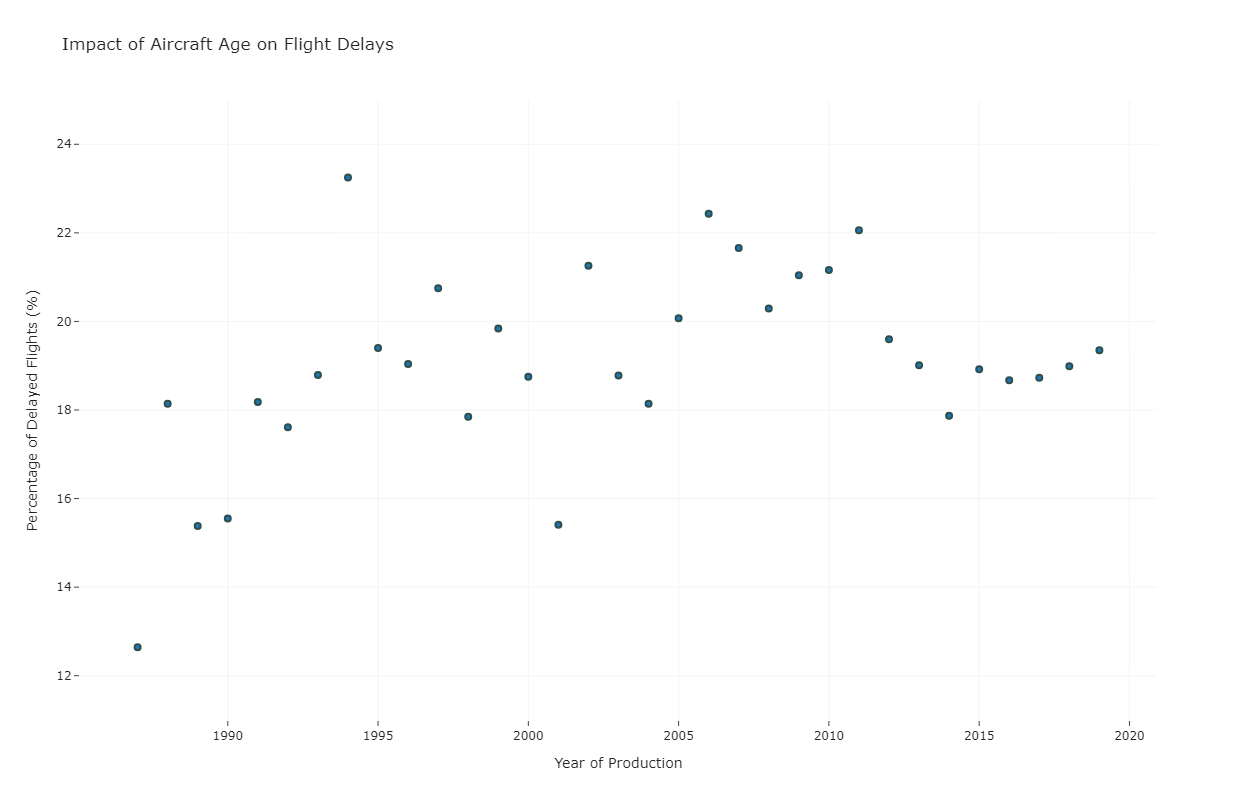

In [159]:
fig = px.scatter(delays_by_manufacture_year_df, x='manufacture_year', y='delay_percentage',
                 title='Impact of Aircraft Age on Flight Delays',
                 labels={'manufacture_year': 'Year of Production', 'delay_percentage': 'Percentage of Delayed Flights (%)'},
                 template='simple_white')

# Dostosowujemy wygląd punktów (obwódki wokół punktów)
fig.update_traces(marker=dict(size=6,
                              line=dict(width=2, color='DarkSlateGrey')))

fig.update_layout(
    width=1200,
    height=800,
    xaxis=dict(showgrid=True, gridwidth=0.5, showline=False),
    yaxis=dict(showgrid=True, gridwidth=0.5, showline=False, range=[11, 25])
)

fig.show()

##### Wyświetlenie wykresu w png - tylko na potrzeby GitHub

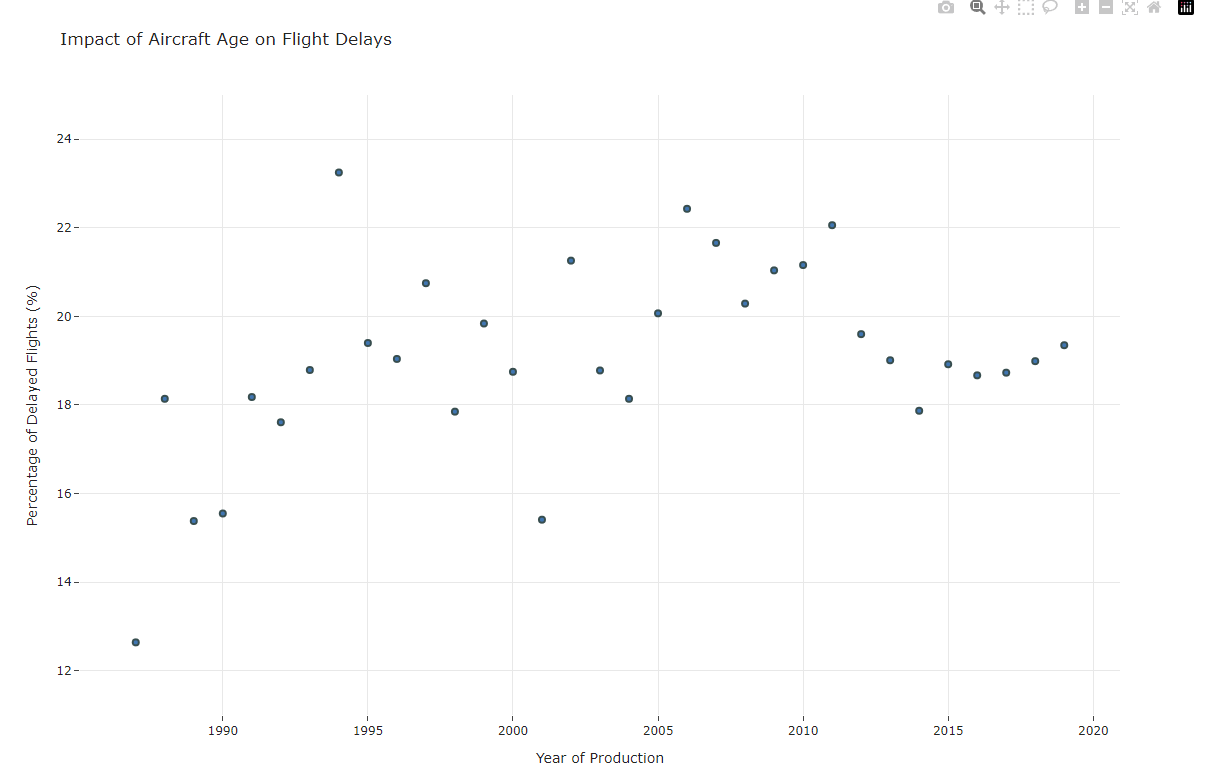

In [14]:
# Wyświetl obraz
Image(filename='../data/png/scr02_01.png')

 ##### Modyfikujemy wykres tak, aby prezentował tylko te roczniki, które odbyły więcej niż 10000 lotów.

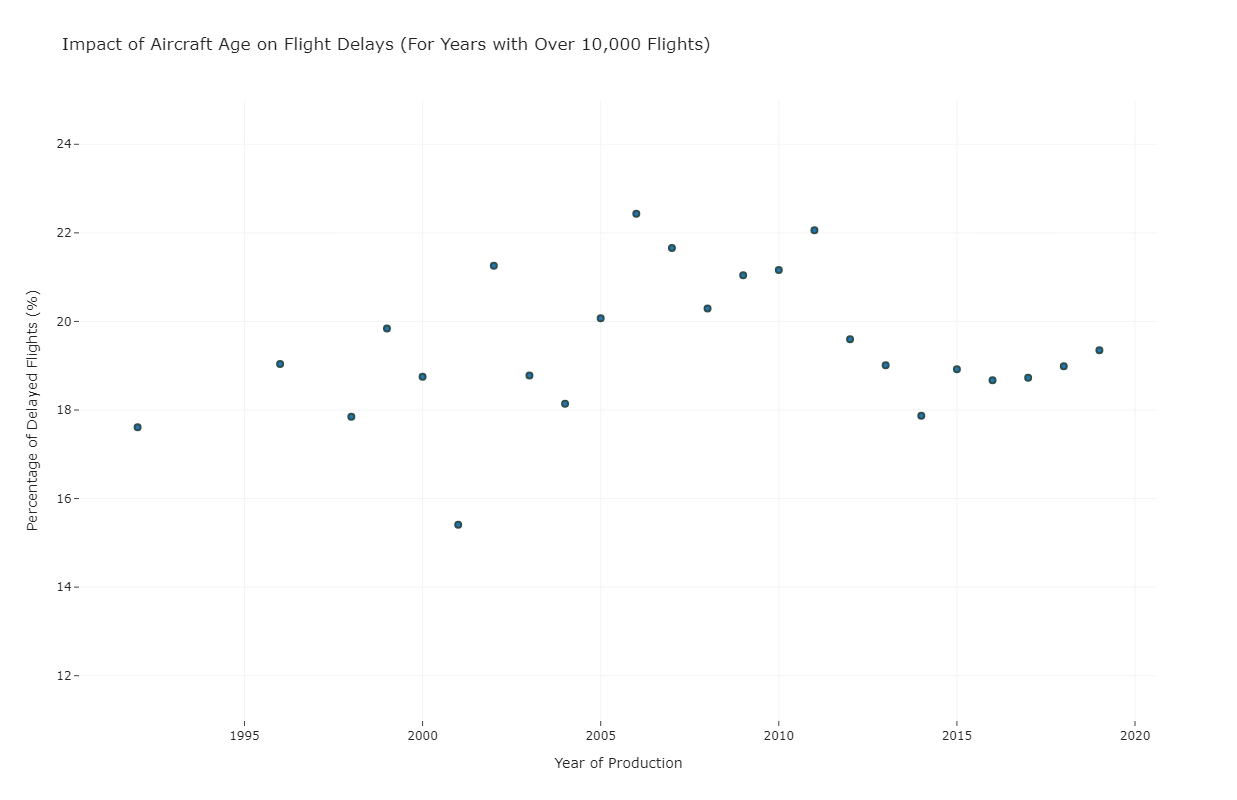

In [189]:
fig2 = px.scatter(delays_by_manufacture_year_df[delays_by_manufacture_year_df['total_flights'] > 10000], x='manufacture_year', y='delay_percentage',
                 title='Impact of Aircraft Age on Flight Delays (For Years with Over 10,000 Flights)',
                 labels={'manufacture_year': 'Year of Production', 'delay_percentage': 'Percentage of Delayed Flights (%)'},
                 template='simple_white')

# Dostosowujemy wygląd punktów (obwódki wokół punktów)
fig2.update_traces(marker=dict(size=6,
                              line=dict(width=2, color='DarkSlateGrey')))

fig2.update_layout(
    width=1200,
    height=800,
    xaxis=dict(showgrid=True, gridwidth=0.5, showline=False),
    yaxis=dict(showgrid=True, gridwidth=0.5, showline=False, range=[11, 25])
)

fig2.show()

##### Wyświetlenie wykresu w png - tylko na potrzeby GitHub

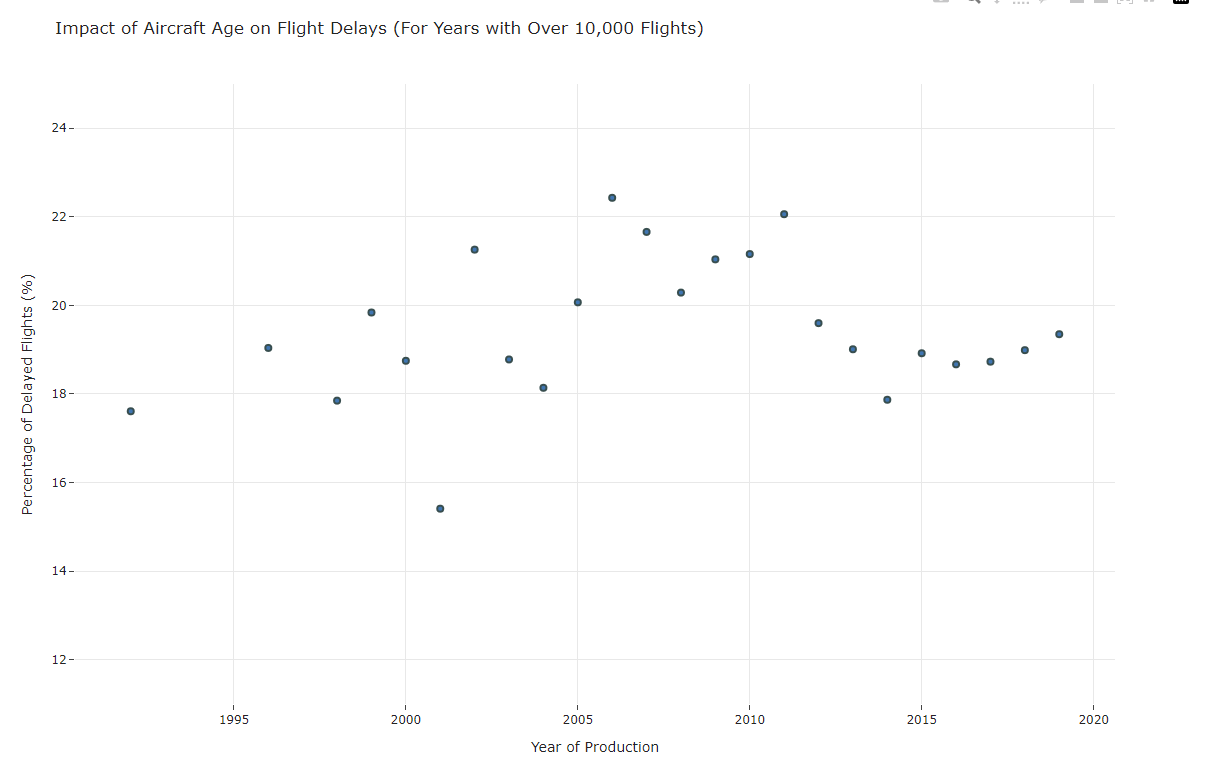

In [11]:
# Wyświetl obraz
Image(filename='../data/png/scr02_02.png')

 ## Opóźnienia vs. rok produkcji samolotu cz. 2
 Dokonujemy agregacji kolumny `manufacture_year` do kolumny `manufacture_year_agg` zgodnie z poniższym:
 1. Grupując dane co 3 lata - wyniki zapisujemy do ramki `flight_delays_by_manufacture_year_agg_df`.
 1. Wyznaczamy top 5 roczników samolotu, które wykonały najwięcej lotów. Wyniki zapisujemy do ramki `top_manufactured_df`, do obliczeń wykorzystujemy `delays_by_manufacture_year_df`.

In [175]:
# Dodajemy nową kolumnę manufacture_year_agg - otrzymana wartość to rok początkowy w tej grupie
flight_df['manufacture_year_agg'] = (flight_df['manufacture_year'] // 3) * 3

Tworzymy zmienną `flight_delays_by_manufacture_year_agg_df`

In [177]:
flight_delays_by_manufacture_year_agg_df  = flight_df.groupby('manufacture_year_agg').agg(
    total_flights=('is_delayed', 'count'),
    delayed_flights=('is_delayed', 'sum')
)

flight_delays_by_manufacture_year_agg_df['delay_percentage'] = ((flight_delays_by_manufacture_year_agg_df['delayed_flights'] / flight_delays_by_manufacture_year_agg_df['total_flights']) * 100).round(2)

In [179]:
flight_delays_by_manufacture_year_agg_df

,total_flights,delayed_flights,delay_percentage
manufacture_year_agg,,,
1986,1077,171,15.88
1989,12500,2146,17.17
1992,24635,4696,19.06
1995,29038,5713,19.67
1998,142550,26843,18.83
2001,157177,27029,17.20
2004,129839,26282,20.24
2007,112640,23571,20.93
2010,76789,15946,20.77


In [181]:
flight_delays_by_manufacture_year_agg_df.reset_index(inplace=True)

In [183]:
flight_delays_by_manufacture_year_agg_df

,manufacture_year_agg,total_flights,delayed_flights,delay_percentage
0,1986,1077,171,15.88
1,1989,12500,2146,17.17
2,1992,24635,4696,19.06
3,1995,29038,5713,19.67
4,1998,142550,26843,18.83
5,2001,157177,27029,17.20
6,2004,129839,26282,20.24
7,2007,112640,23571,20.93
8,2010,76789,15946,20.77
9,2013,160097,29685,18.54


Tworzymy wykres w oparciu o dane zawarte w `flight_delays_by_manufacture_year_agg_df`

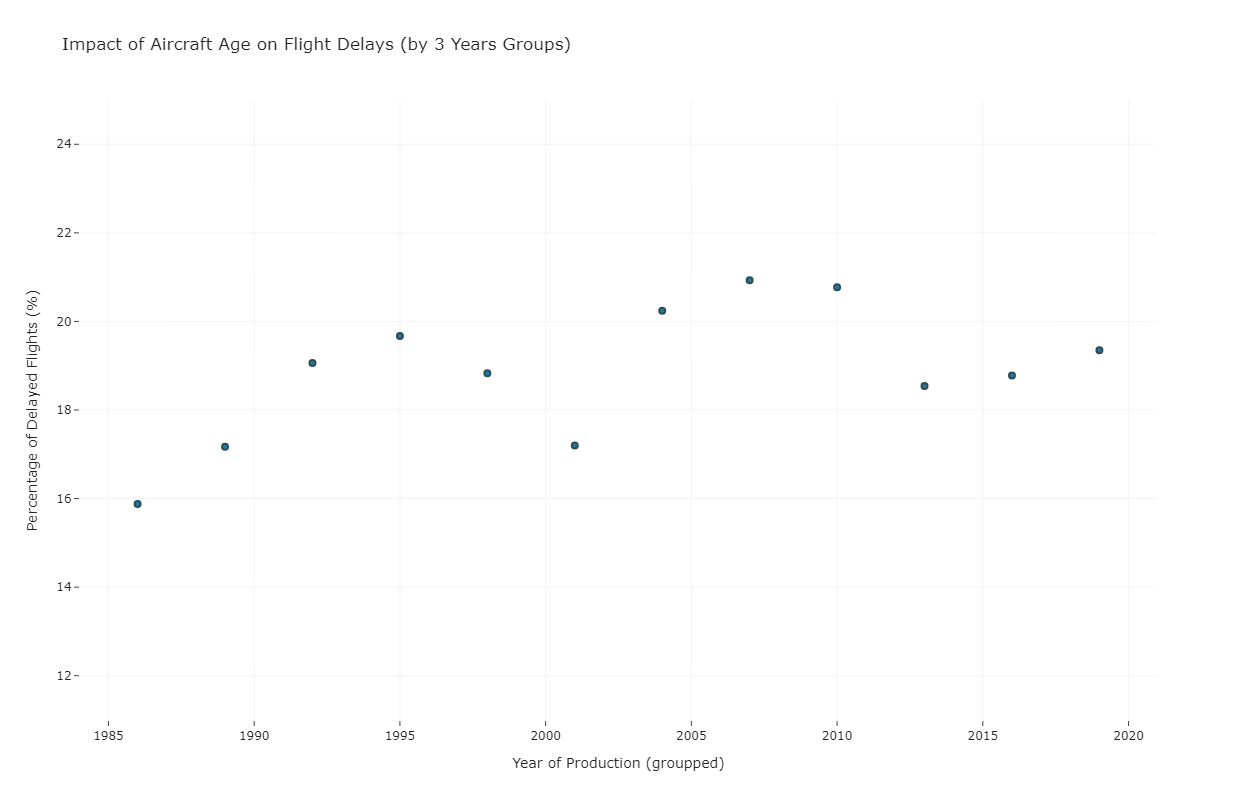

In [195]:
fig3 = px.scatter(flight_delays_by_manufacture_year_agg_df, x='manufacture_year_agg', y='delay_percentage',
                 title='Impact of Aircraft Age on Flight Delays (by 3 Years Groups)',
                 labels={'manufacture_year_agg': 'Year of Production (groupped)', 'delay_percentage': 'Percentage of Delayed Flights (%)'},
                 template='simple_white')

# Dostosowujemy wygląd punktów (obwódki wokół punktów)
fig3.update_traces(marker=dict(size=6,
                              line=dict(width=2, color='DarkSlateGrey')))

fig3.update_layout(
    width=1200,
    height=800,
    xaxis=dict(showgrid=True, gridwidth=0.5, showline=False),
    yaxis=dict(showgrid=True, gridwidth=0.5, showline=False, range=[11, 25])
)

fig3.show()

In [19]:
##### Wyświetlenie wykresu w png - tylko na potrzeby GitHub

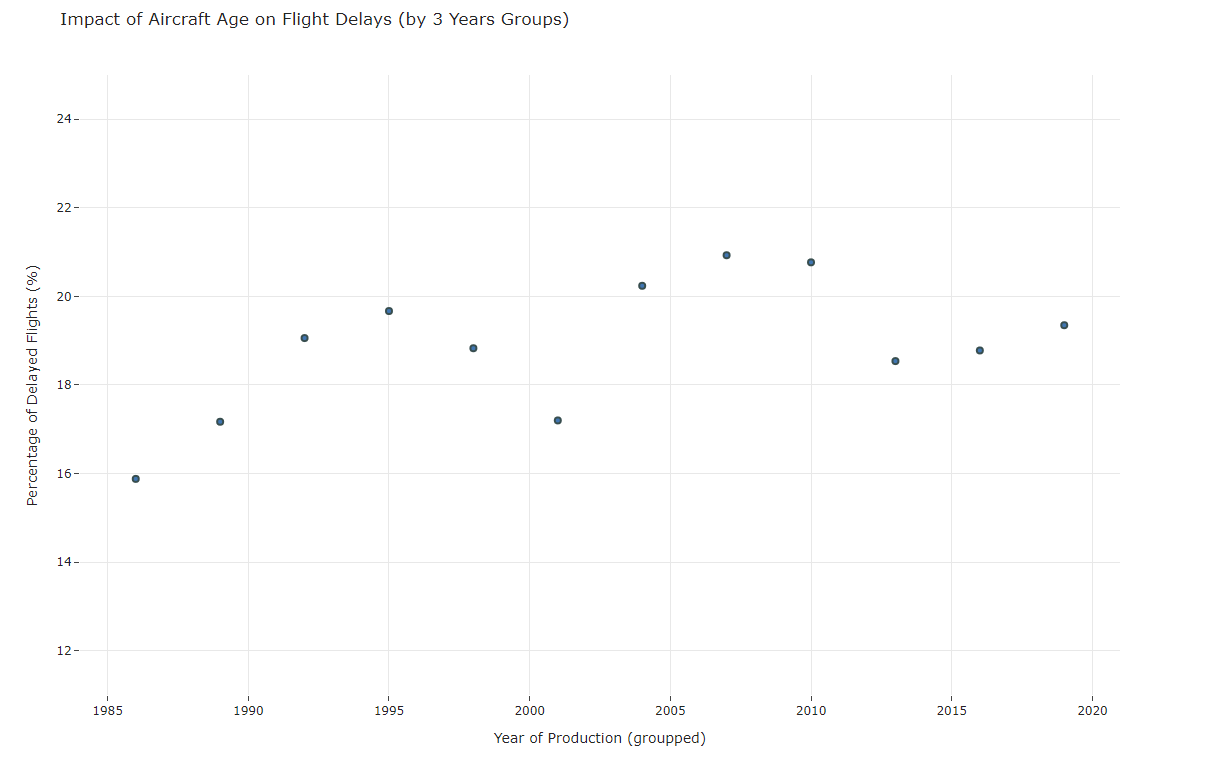

In [21]:
# Wyświetl obraz
Image(filename='../data/png/scr02_03.png')

#####  Po wykonaniu grupowania można dostrzec pewne korelacje pomiędzy rokiem produkcji a procentem opóźnień. W celu dokładniejszej analizy warto zastosować regresję liniową oraz wielomianową, aby zbadać te zależności.

##### Wyznaczamy TOP 5 roczników produkcji - według liczby wykonanych lotów.

In [199]:
# Wyznaczamy TOP 5 roczników produkcji z największą liczbą lotów
top_manufactured_df = delays_by_manufacture_year_df.nlargest(5, 'total_flights')

top_manufactured_df

,manufacture_year,total_flights,delayed_flights,delay_percentage
14,2001,100251,15450,15.41
29,2016,66191,12359,18.67
30,2017,62353,11678,18.73
27,2014,61128,10921,17.87
28,2015,58426,11055,18.92


 # Podsumowanie
 W tym notatniku do naszej wyjściowej ramki danych `flight_df` dołączyliśmy tabelę `aircraft_df` i za jej pomocą dodaliśmy kolejny wymiar do naszej analizy. 

 Zanim przejdziemy dalej, zapisujemy lokalnie bieżącą postać ramki, która zostanie użyta w kolejnym notatniku.

In [203]:
# Ścieżka do zapisu pliku CSV
file_path = '../data/processed/flight_df_02.csv'

# Zapisujemy ramkę danych do pliku CSV
flight_df.to_csv(file_path, index=False)